# DEFINICIÓN DE PARÁMETROS

In [1]:
#######################################################################################################################

# Ruta hacia los CSV del dataset
train_file_relative = '../local/custom_dataset/train'
validation_file_relative = '../local/custom_dataset/validation'
test_file_relative = '../local/custom_dataset/test'

# Ruta al directorio de imágenes con máscara aplicada
masked_dir_relative = '../local/output_masked'
edited_dir_relative = '../local/output_edited'

model_dir_relative = "./models"

# Ruta relativa hacia la librería ai4eutils
ai4eutils_relative = "./repos/ai4eutils"

# Ruta relativa hacia la librería CameraTraps
CameraTraps_relative = "./repos/CameraTraps"

#######################################################################################################################

# DEFINICIÓN PARÁMETROS CNN

In [2]:
#######################################################################################################################

EPOCHS = 50
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

IMG_HEIGHT = IMG_WIDTH = 448

#######################################################################################################################

In [3]:
import os
import platform

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

home = os.path.expanduser("~")

ai4utils = os.path.abspath(ai4eutils_relative)
CameraTraps = os.path.abspath(CameraTraps_relative)
train_file = os.path.abspath(train_file_relative)
validation_file = os.path.abspath(validation_file_relative)
test_file = os.path.abspath(test_file_relative)
masked_dir = os.path.abspath(masked_dir_relative)
edited_dir = os.path.abspath(edited_dir_relative)
model_dir = os.path.abspath(model_dir_relative)

try:
    os.environ['PYTHONPATH']
except KeyError:
    os.environ['PYTHONPATH'] = ""
if platform.system() == 'Windows':
    os.environ['PYTHONPATH'] += (";" + ai4utils)
    os.environ['PYTHONPATH'] += (";" + CameraTraps)
else:
    os.environ['PYTHONPATH'] += (":" + ai4utils)
    os.environ['PYTHONPATH'] += (":" + CameraTraps)

print('==============================================================================================================')
print('PYTHONPATH: ' + os.environ['PYTHONPATH'])
print('')
print('ai4eutils PATH: ' + '\t\t' + ai4utils)
print('CameraTraps PATH: ' + '\t\t' + CameraTraps)
print('Train CSV PATH: ' + '\t\t' + train_file)
print('Validation CSV PATH: ' + '\t' + validation_file)
print('Test CSV PATH: ' + '\t\t\t' + test_file)
print('masked PATH: ' + '\t\t\t' + masked_dir)
print('edited PATH: ' + '\t\t\t' + edited_dir)
print('models PATH: ' + '\t\t\t' + model_dir)
print('==============================================================================================================')

PYTHONPATH: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps

ai4eutils PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils
CameraTraps PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps
Train CSV PATH: 		/Users/carlos/WORKSPACE/local/custom_dataset/train
Validation CSV PATH: 	/Users/carlos/WORKSPACE/local/custom_dataset/validation
Test CSV PATH: 			/Users/carlos/WORKSPACE/local/custom_dataset/test
masked PATH: 			/Users/carlos/WORKSPACE/local/output_masked
edited PATH: 			/Users/carlos/WORKSPACE/local/output_edited
models PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models


# Generate Datasets

In [4]:
custom = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
)

general = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_dataset = custom.flow_from_directory(
    train_file,
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

validation_dataset = general.flow_from_directory(
    validation_file,
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

test_dataset = general.flow_from_directory(
    test_file,
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 1445 images belonging to 2 classes.
Found 312 images belonging to 2 classes.
Found 311 images belonging to 2 classes.


# Custom CNN Architecture

In [5]:
model = keras.Sequential([
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(2, 2),

    # Full connected
    keras.layers.Flatten(),
    keras.layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(LEARNING_RATE), activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(LEARNING_RATE), activation=tf.nn.relu),
    keras.layers.Dropout(0.5),

    # Capa de salida
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[keras.losses.BinaryCrossentropy()],
    metrics=['accuracy'])

Metal device set to: Apple M1


2022-10-18 10:23:27.451783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-18 10:23:27.451916: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2022-10-18 10:23:27.754862: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-18 10:23:28.077623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 0.7460 - accuracy: 0.8146

2022-10-18 10:23:45.801679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 20s 215ms/step - loss: 0.7460 - accuracy: 0.8146 - val_loss: 0.6704 - val_accuracy: 0.9112
Epoch 2/50
90/90 [==============================] - 19s 208ms/step - loss: 0.6777 - accuracy: 0.8978 - val_loss: 0.6283 - val_accuracy: 0.9112
Epoch 3/50
90/90 [==============================] - 19s 206ms/step - loss: 0.5857 - accuracy: 0.8859 - val_loss: 0.4854 - val_accuracy: 0.9112
Epoch 4/50
90/90 [==============================] - 19s 209ms/step - loss: 0.4991 - accuracy: 0.8950 - val_loss: 0.4494 - val_accuracy: 0.9178
Epoch 5/50
90/90 [==============================] - 19s 205ms/step - loss: 0.4779 - accuracy: 0.8985 - val_loss: 0.4499 - val_accuracy: 0.9079
Epoch 6/50
90/90 [==============================] - 18s 204ms/step - loss: 0.4637 - accuracy: 0.8964 - val_loss: 0.4253 - val_accuracy: 0.9178
Epoch 7/50
90/90 [==============================] - 18s 204ms/step - loss: 0.4451 - accuracy: 0.8992 - val_loss: 0.4207 - val_accuracy: 0.9145
Epoch 8/50

KeyError: 'train accuracy'

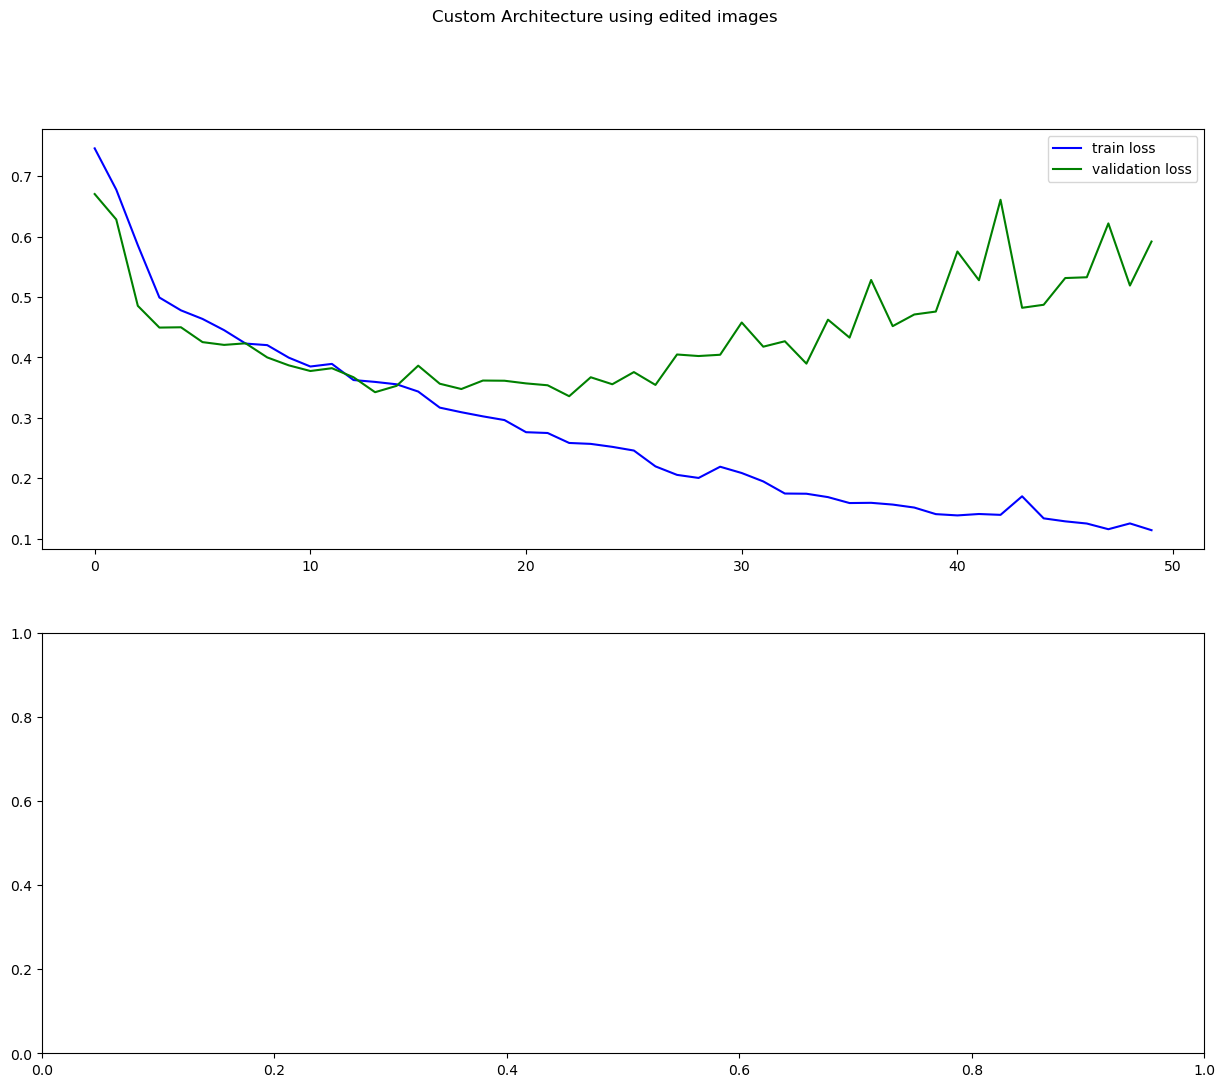

In [6]:
hist = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // BATCH_SIZE,
    verbose=1
)
results = model.evaluate(
    test_dataset,
    batch_size=BATCH_SIZE,
    verbose=1
)

fig = plt.figure(figsize=(15, 12))
fig.suptitle('Custom Architecture using edited images')

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(hist.history['loss'], color='blue', label='train loss', )
ax1.plot(hist.history['val_loss'], color='green', label='validation loss')
ax1.legend(loc="upper right")
ax2.plot(hist.history['accuracy'], color='orange', label='train accuracy')
ax2.plot(hist.history['val_accuracy'], color='red', label='validation accuracy')
ax2.legend(loc="lower right")
plt.show()

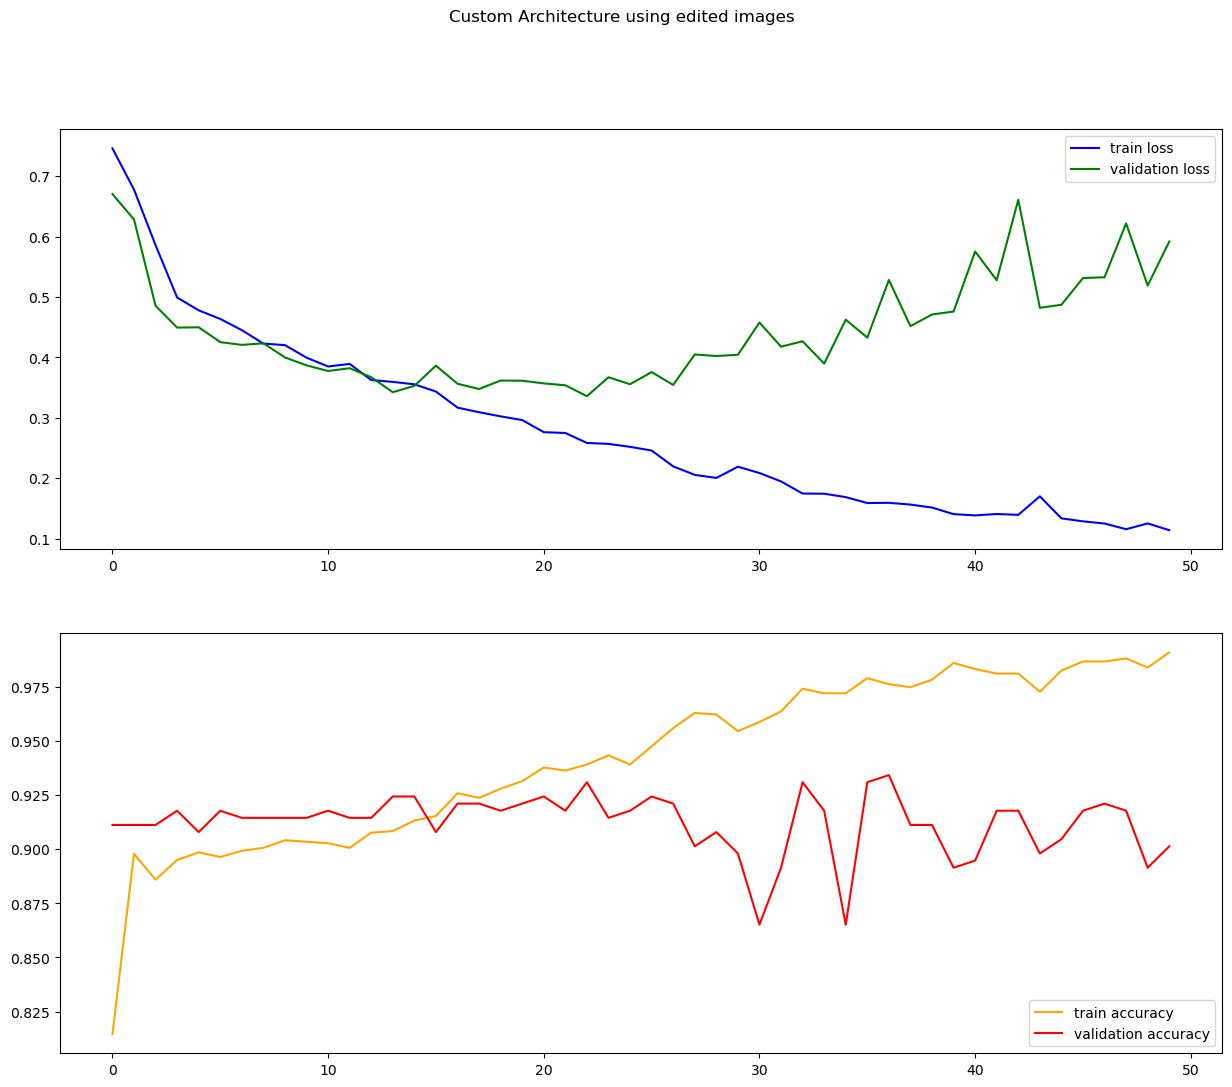

In [7]:
fig = plt.figure(figsize=(15, 12))
fig.suptitle('Custom Architecture using edited images')

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(hist.history['loss'], color='blue', label='train loss', )
ax1.plot(hist.history['val_loss'], color='green', label='validation loss')
ax1.legend(loc="upper right")
ax2.plot(hist.history['accuracy'], color='orange', label='train accuracy')
ax2.plot(hist.history['val_accuracy'], color='red', label='validation accuracy')
ax2.legend(loc="lower right")
plt.show()